# Portfolio Stress Testing with Deep Generative Models

**This code currently is still under development, so for now the results are not the conclusions.**

## Table of Contents

0. [Abstract](#section_0)

1. [Global Variables](#section_1)

2. [Imports and Settings](#section_2)

3. [GPU Configuration](#section_3)

4. [Data Collection and Preprocessing](#section_4)
    - [4.0 Parameters](#section_4_0)
    - [4.1 Portfolio Selection](#section_4_1)
    - [4.2 Download Market Data](#section_4_2)
    - [4.3 Preprocess Market Data](#section_4_3)
    - [4.4 Download and Prepare Macroeconomic Indicators](#section_4_4)
    - [4.5 Prepare Input Features](#section_4_5)

5. [Model Implementation](#section_5)
    - [5.1 Define Custom Layers](#section_5_1)
    - [5.2 Conditional Variational Autoencoder (cVAE)](#section_5_2)
    - [5.3 Conditional Wasserstein GAN (WGAN-GP)](#section_5_3)

6. [Model Training](#section_6)
    - [6.1 Training Parameters](#section_6_1)
    - [6.2 Train Conditional VAE](#section_6_2)
    - [6.3 Train Conditional WGAN-GP](#section_6_3)
    - [6.4 Plot Training Losses](#section_6_4)
    - [6.5 Save & Load Models](#section_6_5)

7. [Scenario Generation and Stress Testing](#section_7)
    - [7.1 Feature Sensitivity Analysis](#section_7_1)
    - [7.2 Backtesting Scenario Creation](#section_7_2)
    - [7.3 Rolling Backtesting](#section_7_3)
    - [7.4 Backtesting Analysis by Stock](#section_7_4)
    - [7.5 Daily Backtesting](#section_7_5)

## TODO ADD
8. [Additional Validation](#section_8)

<a id="section_0"></a>

## Abstract

Financial markets exhibit extreme volatility that often renders traditional risk models insufficient, as these models typically rely on historical data and oversimplified assumptions. This project presents a robust portfolio stress-testing framework based on deep generative models, specifically, a Conditional Variational Autoencoder (cVAE) and a Conditional Wasserstein GAN with Gradient Penalty (WGAN-GP). By conditioning on key macroeconomic indicators such as inflation, interest rates, volatility, and exchange rates, the models generate realistic synthetic return scenarios that capture the complex, nonlinear dependencies between assets during periods of market stress. Applied to a refined selection of Warren Buffett’s Q4 2019 holdings, the framework enables the estimation of critical risk measures, including Value at Risk (VaR) and Expected Shortfall (ES). Additional metrics, such as Earth Mover’s Distance, Jensen-Shannon Divergence, and the Kolmogorov-Smirnov test, are used to validate the fidelity of the generated scenarios against historical data. Moreover, latent space clustering is employed to classify distinct stress regimes, potentially flagging black swan events. The modular design, which encompasses data acquisition, preprocessing, model training, scenario generation, and risk evaluation, provides a flexible and powerful tool for both academic research and practical risk management applications.

<a id="section_1"></a>

## Global Variables

In [1]:
SEED_RANDOM = 29

EPOCHS_WGAN = 1000
EPOCHS_CVAE = 500
LATENT_DIM = 8
NOISE_DIM = 10
WGANGP_PATIENCE = 400

NUM_SCENARIOS = 10000

LOAD_MODEL = True
LOGGING_ENABLED = True
USE_GPU = True

FOLDER_MODELS = "models"

START_DATE = "2004-01-01"
START_BACKTEST = "2020-02-20"
END_BACKTEST = "2020-08-01"
END_DATE = "2021-01-01"

<a id="section_2"></a>

## Imports and Settings

In [2]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

import random
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

import tensorflow as tf

import logging
import warnings

In [3]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
from custom_libraries.start_gpu import gpu_available
from custom_libraries.download_data import (
    download_market_data,
    download_fred_data,
    download_other_data,
)
from custom_libraries.preprocess_data import (
    preprocess_market_data,
    preprocess_macro_data,
    process_input_features,
)
from custom_libraries.utils_plot import (
    plot_missing_values,
    plot_correlation_matrix,
    plot_stock_returns,
    plot_macro_trend,
    plot_gan_losses,
    plot_historical_vs_synthetic_var_period,
    plot_mean_grad_features,
    plot_historical_vs_synthetic_var_period_per_tickers,
)
from custom_libraries.utils import (
    save_models,
    load_models,
)
from custom_libraries.stress_backtesting import (
    rolling_backtest,
    detailed_evaluation_forecast,
    backtest_tickers_ret_syn,
)
from custom_libraries.utils_plot import (
    plot_bar_diff,
    plot_scatter_actual_vs_synthetic_oblique,
    plot_latent_space_clustering,
    plot_distribution_synthetic_portfolio,
    plot_tail_histogram,
)
from custom_libraries.validation import (
    filter_tail,
    compare_tail_distributions,
    adversarial_tail_test
)

In [5]:
if LOGGING_ENABLED:
    logging.basicConfig(filename="debug.log", level=logging.INFO)
else:
    logging.basicConfig(level=logging.CRITICAL)

<a id="section_3"></a>

## GPU Configuration

In [6]:
gpu_available(USE_GPU)

Number of GPUs Available: 0
No GPU found. Running on CPU.


<a id="section_4"></a>

## Data Collection and Preprocessing

<a id="section_4_0"></a>

### Parameters

In [7]:
np.random.seed(SEED_RANDOM)
random.seed(SEED_RANDOM)
tf.random.set_seed(SEED_RANDOM)

start_date = START_DATE
backtest_start = START_BACKTEST
backtest_end = END_BACKTEST
end_date = END_DATE

# To allow forward fill, download macro data starting 1 year earlier
pre_start_date = (pd.to_datetime(start_date) - pd.DateOffset(years=1)).strftime(
    "%Y-%m-%d"
)

<a id="section_4_1"></a>
### Portfolio Selection

Tickers: [Warren Buffett's 2019 Q4 portfolio](https://valuesider.com/guru/warren-buffett-berkshire-hathaway/portfolio/2019/4?sort=-percent_portfolio&sells_page=1&page=2).

In [8]:
portfolio_df = pd.read_csv("portfolio.csv")
tickers = portfolio_df["ticker"].tolist()

portfolio_df["weight"] = portfolio_df["weight"] / 100.0
portfolio_weights = portfolio_df["weight"].values

<a id="section_4_2"></a>
### Download Market Data

In [9]:
market_data = download_market_data(tickers, pre_start_date, end_date)
market_data.head()

YF.download() has changed argument auto_adjust default to True


Price          Close                                                      \
Ticker          AAPL    AMZN        AXP        BAC       BIIB         BK   
Date                                                                       
2003-01-02  0.222693  0.9785  23.316624  20.762495  34.340000  15.763540   
2003-01-03  0.224197  1.0260  23.399275  20.633249  33.689999  15.869796   
2003-01-06  0.224197  1.0350  24.219521  20.929937  34.230000  16.663609   
2003-01-07  0.223445  1.0775  23.895239  20.962257  34.240002  16.588596   
2003-01-08  0.218931  1.0510  23.717203  20.877052  33.029999  15.938555   

Price                                                  ...   Volume          \
Ticker           COST       DVA         GL         GS  ...      PNC    SIRI   
Date                                                   ...                    
2003-01-02  19.460592  8.363333  13.452590  50.043797  ...   792500  225260   
2003-01-03  18.950764  8.460000  13.459773  50.568325  ...  1109100  117150   
2003-01-06  19.178846  8.483333  13.676064  52.450794  ...  1756200  162380   
2003-01-07  19.487425  8.416667  13.517454  52.235241  ...  1597900  641390   
2003-01-08  19.655123  8.376667  13.481402  50.956310  ...  1335400  553830   

Price                                                                       \
Ticker           SPY      SU     TEVA      TRV      UPS      USB      VRSN   
Date                                                                         
2003-01-02  44516300  864800  6000400   833000  2805000  5131000   6949000   
2003-01-03  32222600  757200  4711600   961100  1935500  3398700   3147300   
2003-01-06  40984500  718000  7149600  1200300  3052500  6704900   5064200   
2003-01-07  38640400  631600  6454800  1441100  2370400  5067900  10772800   
2003-01-08  38702200  751200  3277400  1385300  1680900  3579900  10515000   

Price                
Ticker          WFC  
Date                 
2003-01-02  9904200  
2003-01-03  7808000  
2003-01-06  8097400  
2003-01-07  6556200  
2003-01-08  8071000  

[5 rows x 150 columns]

<a id="section_4_3"></a>
### Preprocess Market Data

In [10]:
returns_all, returns_train, returns_test, returns_train_scaled, returns_scaler = (
    preprocess_market_data(market_data, start_date, backtest_start, backtest_end)
)
returns_train.head()

Ticker          AAPL      AMZN       AXP       BAC      BIIB        BK  \
Date                                                                     
2004-01-02 -0.004220 -0.013777 -0.010002 -0.016801  0.006518 -0.009404   
2004-01-05  0.040973  0.026055  0.008757  0.002904  0.004322  0.040907   
2004-01-06 -0.003616 -0.004516  0.001660 -0.001640  0.039376  0.015387   
2004-01-07  0.022383 -0.021539  0.002897 -0.002276  0.055444 -0.035184   
2004-01-08  0.033518 -0.032507 -0.002897  0.000506  0.011214 -0.001195   

Ticker          COST       DVA        GL        GS  ...       PNC      SIRI  \
Date                                                ...                       
2004-01-02 -0.023403  0.012992  0.000439 -0.016339  ... -0.004395  0.189678   
2004-01-05 -0.004691  0.011075  0.007016  0.000515  ... -0.013488 -0.087487   
2004-01-06  0.011278 -0.012341 -0.002625 -0.005986  ...  0.008336 -0.040822   
2004-01-07  0.014123 -0.004063 -0.001096  0.020797  ... -0.002956 -0.058209   
2004-01-08  0.004843 -0.006894  0.000000  0.001216  ... -0.003150  0.058209   

Ticker           SPY        SU      TEVA       TRV       UPS       USB  \
Date                                                                     
2004-01-02 -0.000450  0.016228  0.020249 -0.001262 -0.012146 -0.007314   
2004-01-05  0.010820  0.008989  0.027104  0.002522  0.003794 -0.009999   
2004-01-06  0.000978  0.018887 -0.016277 -0.007585 -0.006105 -0.015011   
2004-01-07  0.003371 -0.017720 -0.003939  0.000000 -0.003272 -0.000704   
2004-01-08  0.003977 -0.027582 -0.002233  0.006325 -0.008226 -0.006710   

Ticker          VRSN       WFC  
Date                            
2004-01-02  0.002451 -0.012303  
2004-01-05  0.045462  0.004803  
2004-01-06  0.045722 -0.003256  
2004-01-07 -0.017470 -0.010179  
2004-01-08  0.043933 -0.000347  

[5 rows x 30 columns]

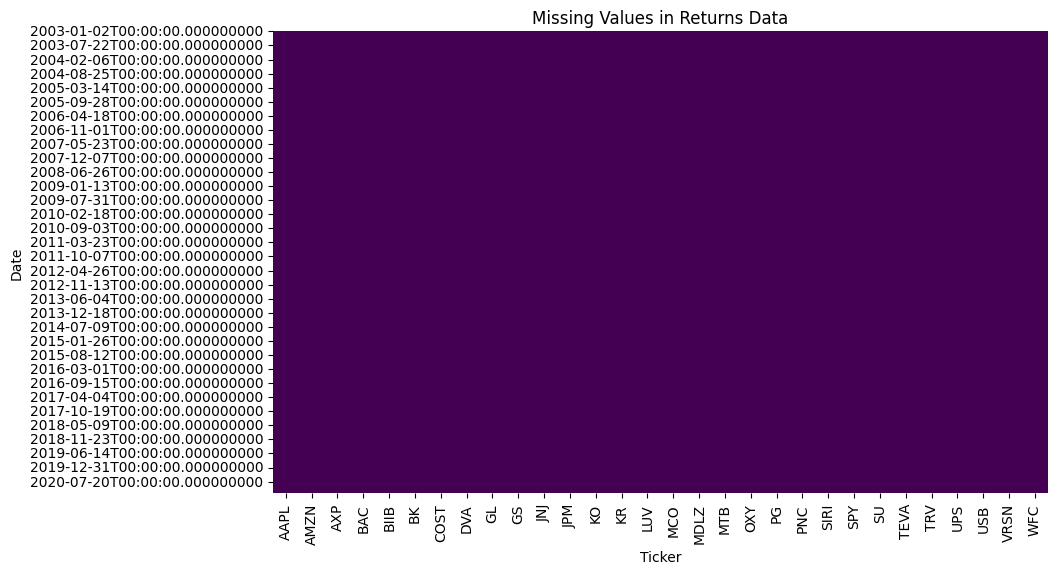

In [11]:
plot_missing_values(returns_all, "Missing Values in Returns Data")

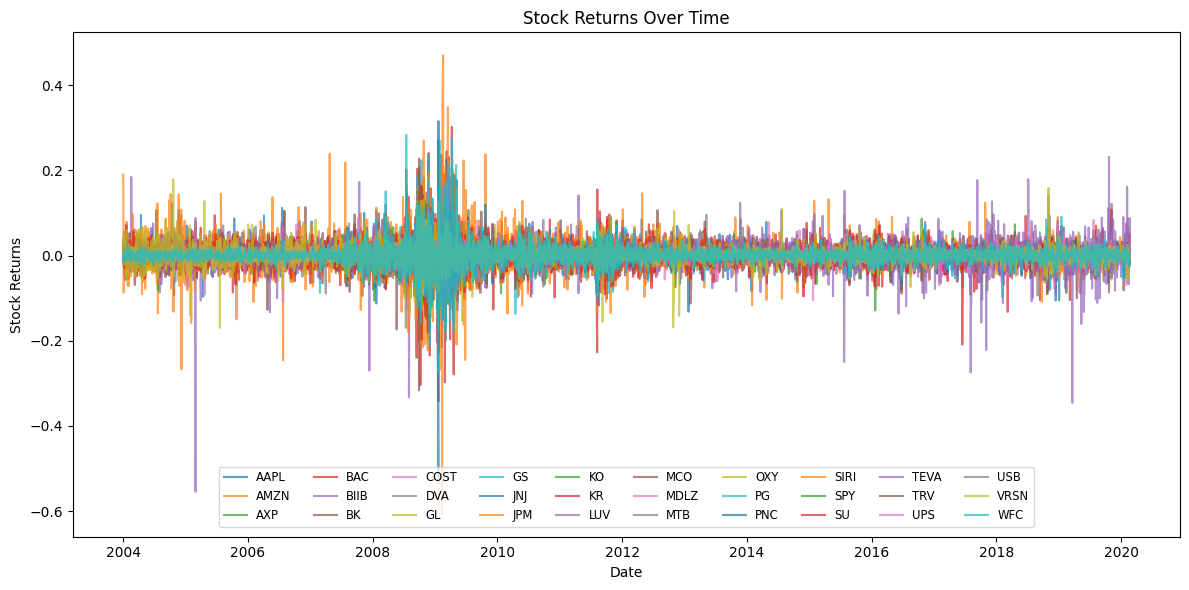

In [12]:
plot_stock_returns(returns_train)

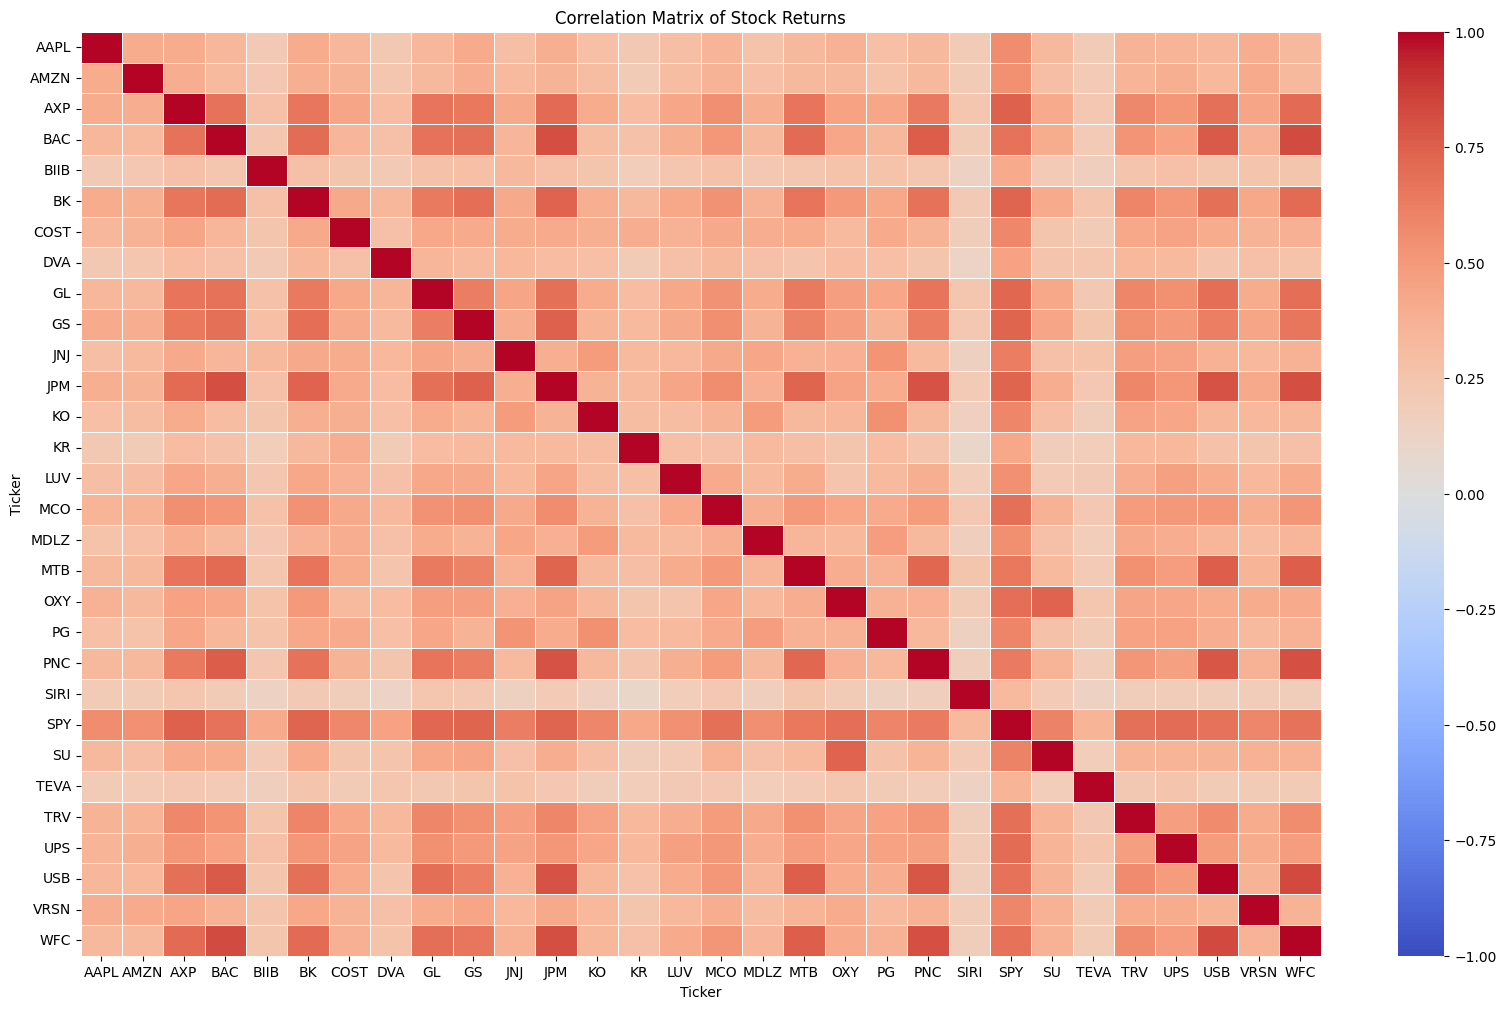

In [13]:
plot_correlation_matrix(
    returns_train, "Correlation Matrix of Stock Returns", figsize=(20, 12), annot=False
)

<a id="section_4_4"></a>
### Download and Prepare Macroeconomic Indicators

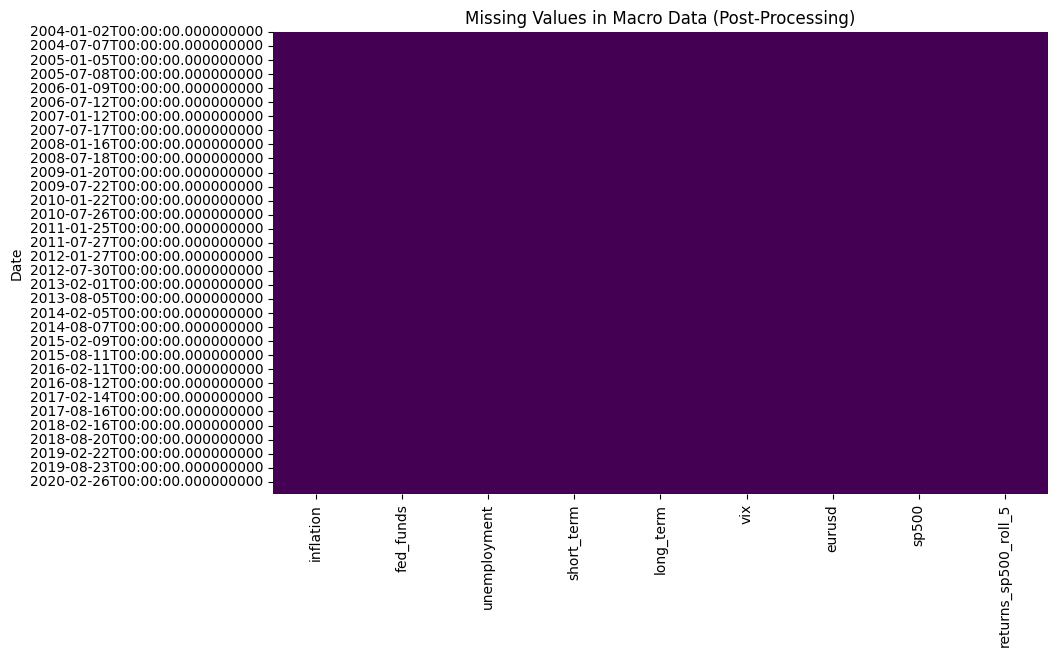

In [14]:
# Load FRED API Key
with open("key_fred.txt", "r") as file:
    fred_api_key = file.read().strip()

# Download FRED series
fred_data = download_fred_data(fred_api_key, pre_start_date, end_date)
vix_data, fx_data, sp500_data = download_other_data(pre_start_date, end_date)

macro_df = preprocess_macro_data(
    fred_data, vix_data, fx_data, sp500_data, start_date, backtest_end, returns_all.index
)

In [15]:
macro_df.head()

inflation  fed_funds  unemployment  short_term  long_term  \
Date                                                                    
2004-01-02   2.270095       0.98           5.7        0.95       4.27   
2004-01-05   2.677237       1.00           5.7        0.93       4.38   
2004-01-06   2.677237       1.00           5.7        0.91       4.41   
2004-01-07   2.677237       1.00           5.7        0.91       4.29   
2004-01-08   2.677237       1.00           5.7        0.91       4.27   

                  vix    eurusd     sp500  returns_sp500_roll_5  
Date                                                             
2004-01-02  18.309999  1.259002  0.002053             -0.003099  
2004-01-05  18.219999  1.258194 -0.003099              0.000000  
2004-01-06  17.490000  1.268698  0.012319             -0.000321  
2004-01-07  16.730000  1.272103  0.001291             -0.001612  
2004-01-08  15.500000  1.264095  0.002364             -0.004547

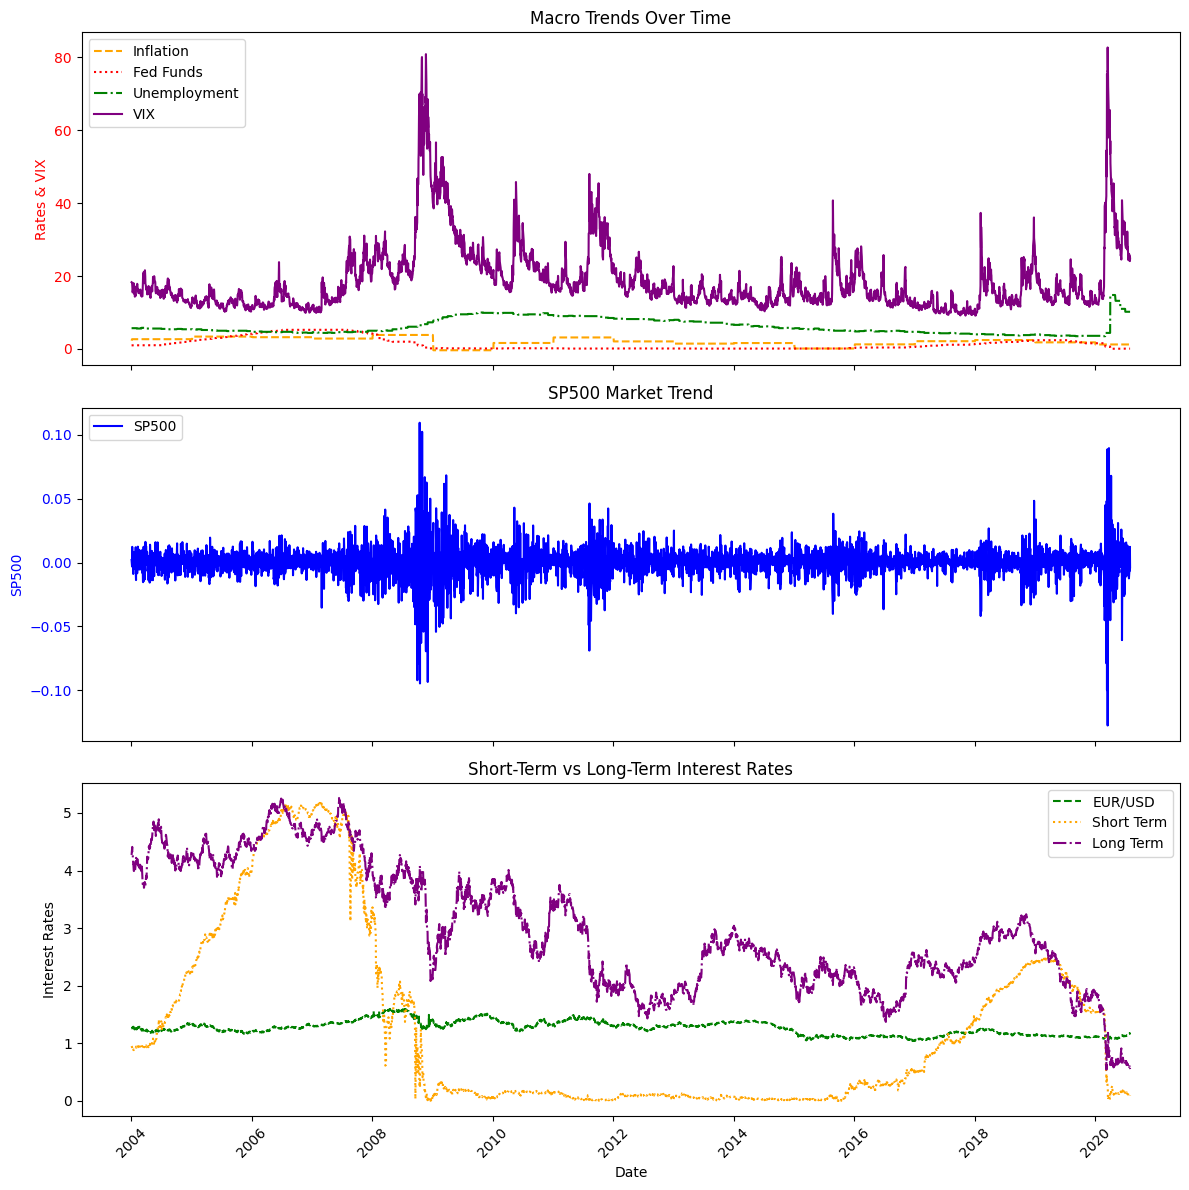

In [16]:
plot_macro_trend(macro_df)

<a id="section_4_5"></a>
### Prepare Input Features

In [17]:
input_features = process_input_features(
    macro_df,
    returns_all,
    market_data,
    start_date,
    end_date,
    portfolio_weights,
)

input_features.head()

inflation  fed_funds  unemployment  short_term  long_term  \
Date                                                                    
2004-01-02   2.270095       0.98           5.7        0.95       4.27   
2004-01-05   2.677237       1.00           5.7        0.93       4.38   
2004-01-06   2.677237       1.00           5.7        0.91       4.41   
2004-01-07   2.677237       1.00           5.7        0.91       4.29   
2004-01-08   2.677237       1.00           5.7        0.91       4.27   

                  vix    eurusd     sp500  returns_sp500_roll_5  \
Date                                                              
2004-01-02  18.309999  1.259002  0.002053             -0.003099   
2004-01-05  18.219999  1.258194 -0.003099              0.000000   
2004-01-06  17.490000  1.268698  0.012319             -0.000321   
2004-01-07  16.730000  1.272103  0.001291             -0.001612   
2004-01-08  15.500000  1.264095  0.002364             -0.004547   

            portfolio_volatility  portfolio_volume  
Date                                                
2004-01-02              0.011617      7.338336e+07  
2004-01-05              0.012135      1.742616e+08  
2004-01-06              0.012069      1.974032e+08  
2004-01-07              0.012103      2.344443e+08  
2004-01-08              0.010964      1.942956e+08

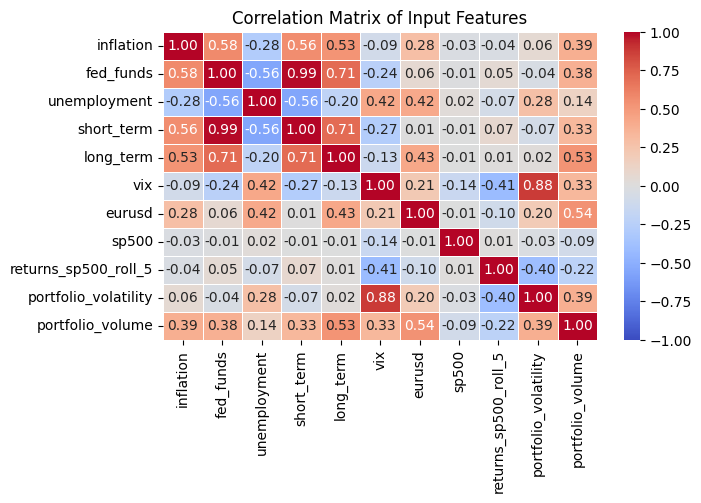

In [18]:
plot_correlation_matrix(input_features, "Correlation Matrix of Input Features")

In [19]:
print(f"#Nan in Input Features : {input_features.isna().sum().sum()}")

#Nan in Input Features : 0


In [20]:
input_train = input_features.loc[start_date:backtest_start]
input_test = input_features.loc[backtest_start:backtest_end]

# Scale input_features indicators
input_scaler = StandardScaler()
input_train_scaled = input_scaler.fit_transform(input_train)
input_test_scaled = input_scaler.transform(input_test)

<a id="section_5"></a>

## Model Implementation

<a id="section_5_1"></a>
### Define Custom Layers

In [21]:
from custom_libraries.custome_layer import (
    KLDivergenceLayer,
    SamplingLayer,
    ReconstructionLossLayer,
)

# Define the missing custom layer
custom_objects = {
    "KLDivergenceLayer": KLDivergenceLayer,
    "ReconstructionLossLayer": ReconstructionLossLayer,
    "SamplingLayer": SamplingLayer,
}

<a id="section_5_2"></a>
### Conditional Variational Autoencoder (cVAE)

In [22]:
from custom_libraries.custom_vae import (
    build_conditional_vae,
)

<a id="section_5_2"></a>
### Conditional Wasserstein GAN (WGAN-GP)

In [23]:
from custom_libraries.custom_wgangp import (
    build_conditional_generator,
    build_conditional_critic,
    train_conditional_wgan_gp,
)

<a id="section_6"></a>
## Model Training

<a id="section_6_1"></a>
### Training Parameters

In [24]:
n_samples = min(returns_train_scaled.shape[0], input_train_scaled.shape[0])
returns_scaled = returns_train_scaled[:n_samples]
macro_train_scaled = input_train_scaled[:n_samples]

In [25]:
return_dim = returns_scaled.shape[1]
input_dim = input_train_scaled.shape[1]
latent_dim = LATENT_DIM
noise_dim = NOISE_DIM

print(f"Returns dim: {return_dim}")
print(f"Input dim: {input_dim}")
print(f"Latent dim: {latent_dim}")
print(f"Noise dim: {noise_dim}")

Returns dim: 30
Input dim: 11
Latent dim: 8
Noise dim: 10


<a id="section_6_2"></a>
### Train Conditional VAE

In [26]:
if not LOAD_MODEL:
    print("Training Conditional VAE...")
    encoder, decoder, cvae, early_stop = build_conditional_vae(
        return_dim, input_dim, intermediate_dim=256, latent_dim=latent_dim
    )

    cvae.fit(
        [returns_scaled, input_train_scaled],
        epochs=EPOCHS_CVAE,
        batch_size=32,
        validation_split=0.1,
        callbacks=[early_stop],
        verbose=1
    )
    z_mean_train, _, _ = encoder.predict(returns_scaled)

<a id="section_6_3"></a>
### Train Conditional WGAN-GP

In [27]:
if not LOAD_MODEL:
    print("Training Conditional WGAN-GP...")
    generator = build_conditional_generator(noise_dim, input_dim, latent_dim)
    critic = build_conditional_critic(latent_dim, input_dim)
    generator, gen_losses, critic_losses, val_losses = train_conditional_wgan_gp(
        generator,
        critic,
        z_mean_train,
        input_train_scaled,
        input_test,
        noise_dim,
        epochs=EPOCHS_WGAN,
        important_index="returns_sp500_roll_5",
        patience=WGANGP_PATIENCE,
    )

<a id="section_6_4"></a>
### Plot Training Losses

In [28]:
if not LOAD_MODEL:
    plot_gan_losses(gen_losses, critic_losses, val_losses)

<a id="section_6_5"></a>
### Save & Load Models

In [29]:
if LOAD_MODEL:
    encoder, decoder, cvae, generator, critic = load_models(
        custom_objects, FOLDER_MODELS
    )
    print("Load models")
else:
    save_models(encoder, decoder, cvae, generator, critic, FOLDER_MODELS)
    print("Save models")

Load models


<a id="section_7"></a>

## Scenario Generation and Stress Testing

<a id="section_7_1"></a>
### Feature Sensitivity Analysis

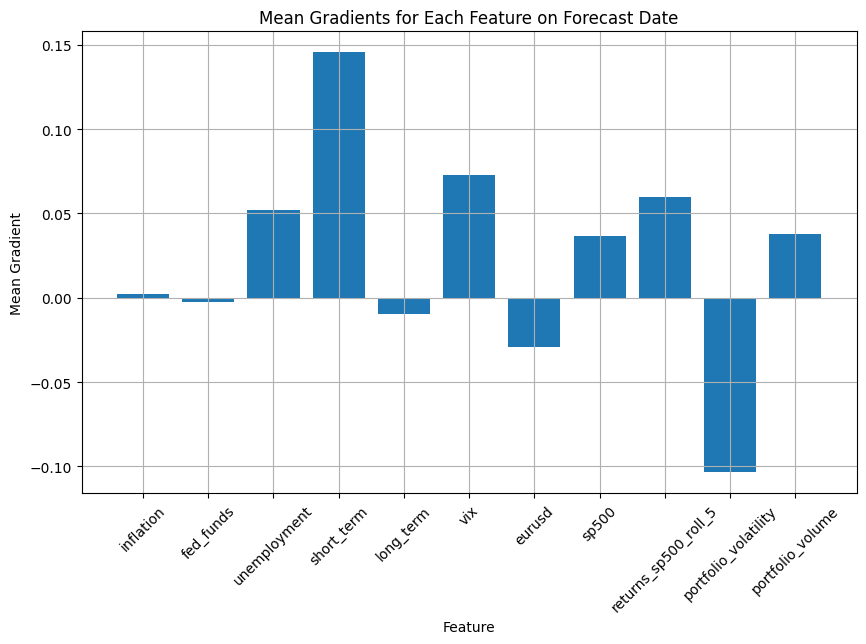

In [30]:
plot_mean_grad_features(input_test, generator)

<a id="section_7_2"></a>
### Backtesting Scenario Creation

In [31]:
input_test.describe()

inflation   fed_funds  unemployment  short_term  long_term  \
count  114.000000  114.000000    114.000000  114.000000  114.00000   
mean     1.233584    0.286316     10.138596    0.264825    0.76000   
std      0.000000    0.424204      3.920911    0.375625    0.20985   
min      1.233584    0.050000      3.500000    0.000000    0.54000   
25%      1.233584    0.050000      4.400000    0.120000    0.64000   
50%      1.233584    0.080000     11.000000    0.140000    0.69000   
75%      1.233584    0.650000     13.200000    0.170000    0.76000   
max      1.233584    1.580000     14.800000    1.580000    1.56000   

              vix      eurusd       sp500  returns_sp500_roll_5  \
count  114.000000  114.000000  114.000000            114.000000   
mean    36.983070    1.109454   -0.000329             -0.026899   
std     13.655646    0.025367    0.030644              0.040053   
min     14.380000    1.065735   -0.127652             -0.188892   
25%     27.872500    1.086396   -0.010565             -0.038297   
50%     32.990000    1.104979    0.003294             -0.008475   
75%     41.327500    1.127857    0.013232              0.000000   
max     82.690002    1.178287    0.089683              0.000000   

       portfolio_volatility  portfolio_volume  
count            114.000000      1.140000e+02  
mean               0.028129      8.899101e+07  
std                0.015233      3.531846e+07  
min                0.009549      4.316052e+07  
25%                0.017136      6.481707e+07  
50%                0.018154      7.813979e+07  
75%                0.044860      1.033818e+08  
max                0.056147      1.974422e+08

In [32]:
stress_values = {
#    "returns_sp500_roll_5": -0.2,
}


<a id="section_7_3"></a>
### Rolling Backtesting

In [33]:
backtest_df = rolling_backtest(
    returns_test,
    input_test,
    input_scaler,
    input_test_scaled,
    NOISE_DIM,
    generator,
    decoder,
    returns_scaler,
    NUM_SCENARIOS,
    portfolio_weights,
    stress_values,
)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
313/313 ━━━

In [34]:
print("Rolling backtest results:")
backtest_df.head()

Rolling backtest results:


forecast_date  hist_portfolio_return  synthetic_VaR  synthetic_ES  \
0    2020-02-20              -0.006224      -0.039051     -0.039190   
1    2020-02-21              -0.016265      -0.037949     -0.038193   
2    2020-02-24              -0.042082      -0.056849     -0.057372   
3    2020-02-25              -0.032877      -0.040660     -0.041263   
4    2020-02-26               0.001837      -0.025591     -0.025967   

                                   synthetic_returns  
0  [-0.036629522625088194, -0.03666818122044929, ...  
1  [-0.03765579172528911, -0.036201523868142856, ...  
2  [-0.04968697251457453, -0.04992855156075434, -...  
3  [-0.03587752483093043, -0.03818260404836201, -...  
4  [-0.022536671882056825, -0.022696507608042253,...

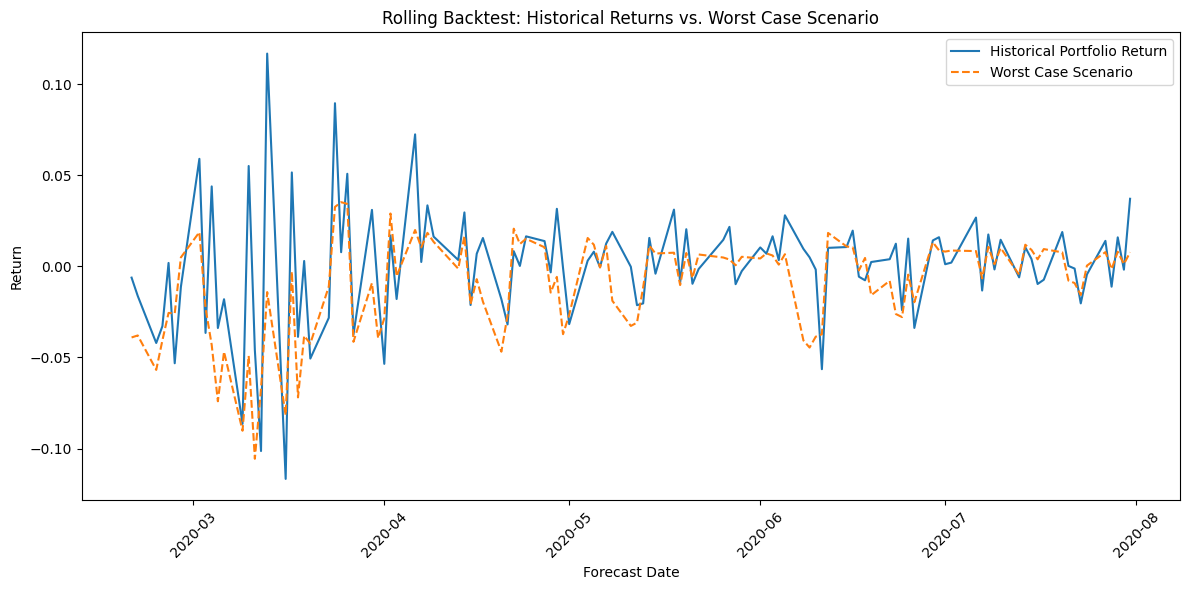

In [35]:
plot_historical_vs_synthetic_var_period(backtest_df)

<a id="section_7_4"></a>
### Backtesting Analysis by Stock

In [36]:
backtest_tickers_df = rolling_backtest(
    returns_test,
    input_test,
    input_scaler,
    input_test_scaled,
    NOISE_DIM,
    generator,
    decoder,
    returns_scaler,
    NUM_SCENARIOS,
    portfolio_weights,
    stress_values,
    by_ticker=True,
)

  1/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step
313/313 ━━━

In [37]:
print("Rolling backtest results:")
backtest_tickers_df.head()

Rolling backtest results:


forecast_date  hist_return_AAPL  hist_return_AMZN  hist_return_AXP  \
0    2020-02-20         -0.010312         -0.007920        -0.002559   
1    2020-02-21         -0.022895         -0.026892        -0.012377   
2    2020-02-24         -0.048666         -0.042235        -0.051020   
3    2020-02-25         -0.034459         -0.018358        -0.058550   
4    2020-02-26          0.015739          0.003466        -0.020051   

   hist_return_BAC  hist_return_BIIB  hist_return_BK  hist_return_COST  \
0         0.003737         -0.012986       -0.001961          0.003276   
1        -0.014160          0.000208       -0.017388         -0.006594   
2        -0.048601         -0.032386       -0.043332         -0.026214   
3        -0.051727         -0.005753       -0.036359         -0.028296   
4        -0.014585          0.010252       -0.005304          0.002686   

   hist_return_DVA  hist_return_GL  ...  synthetic_ES_PNC  synthetic_ES_SIRI  \
0        -0.009874        0.005322  ...         -0.029347          -0.057763   
1        -0.006638       -0.009218  ...         -0.027944          -0.057300   
2        -0.014735       -0.032012  ...         -0.043831          -0.081884   
3        -0.022086       -0.034234  ...         -0.028681          -0.064654   
4        -0.000123       -0.022963  ...         -0.016260          -0.044029   

   synthetic_ES_SPY  synthetic_ES_SU  synthetic_ES_TEVA  synthetic_ES_TRV  \
0         -0.023722        -0.045811          -0.043946         -0.024317   
1         -0.022494        -0.045381          -0.042318         -0.023126   
2         -0.033758        -0.070794          -0.057949         -0.036589   
3         -0.021029        -0.052738          -0.041311         -0.022581   
4         -0.011080        -0.032247          -0.027637         -0.011965   

   synthetic_ES_UPS  synthetic_ES_USB  synthetic_ES_VRSN  synthetic_ES_WFC  
0         -0.023970         -0.037228          -0.049666         -0.031722  
1         -0.023746         -0.035686          -0.047853         -0.030345  
2         -0.036273         -0.053075          -0.070089         -0.049928  
3         -0.027393         -0.037835          -0.050048         -0.035931  
4         -0.017975         -0.023576          -0.031744         -0.021618  

[5 rows x 91 columns]

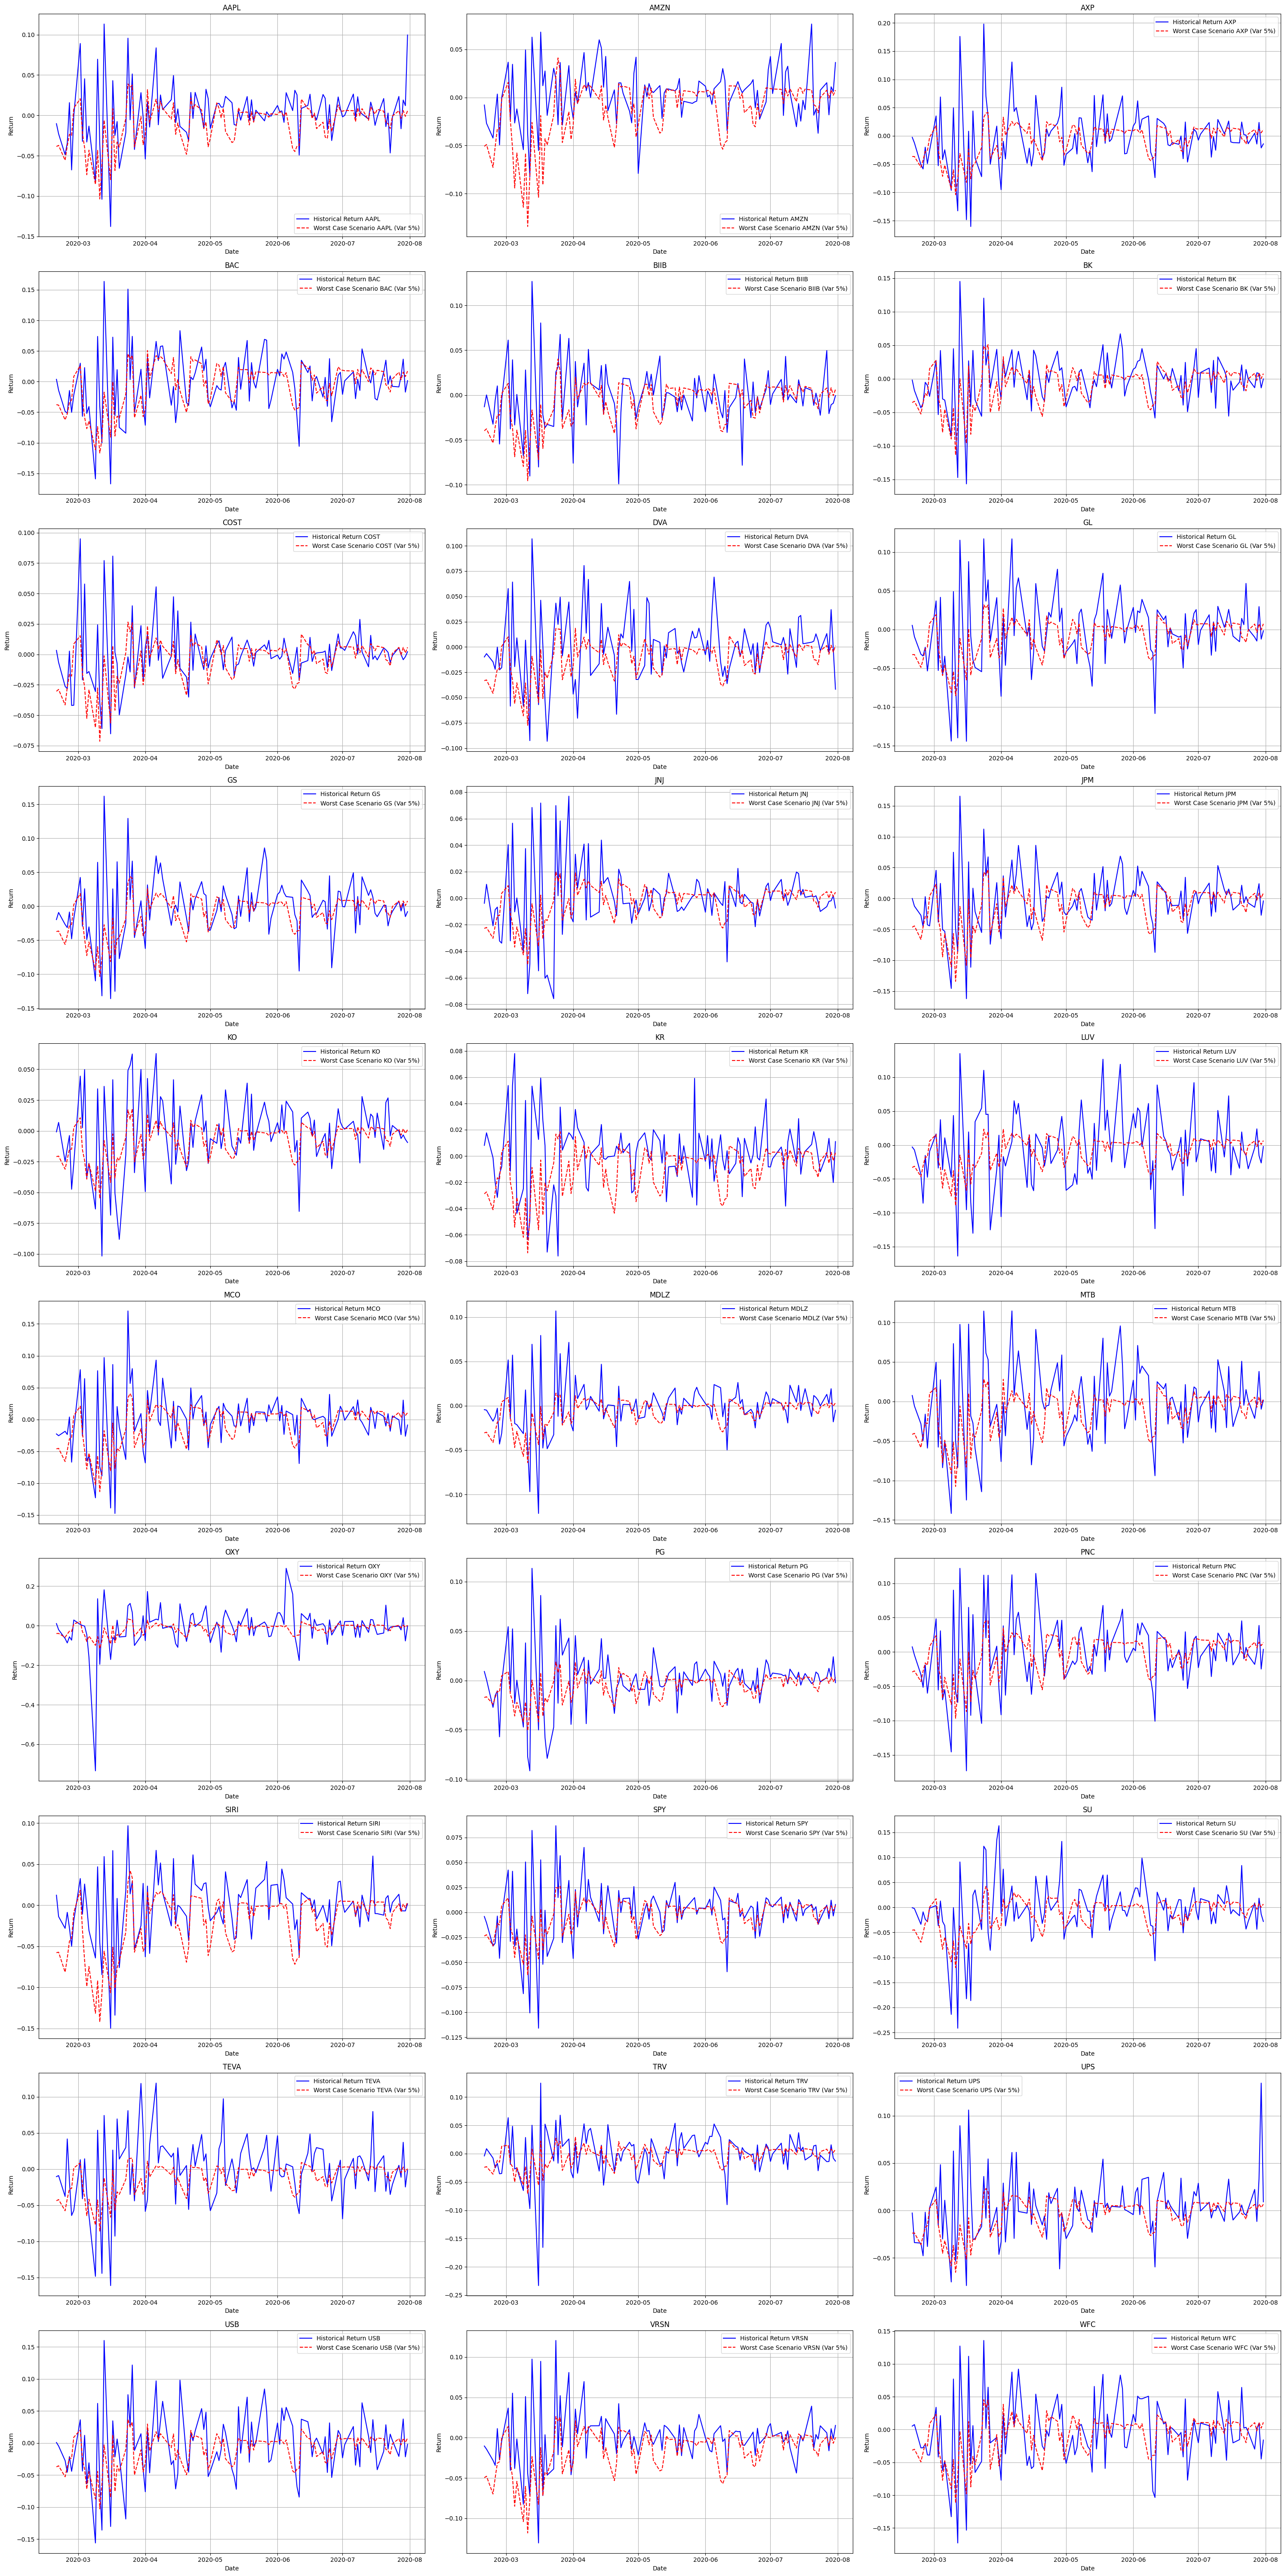

In [38]:
plot_historical_vs_synthetic_var_period_per_tickers(backtest_tickers_df, returns_test)

In [39]:
tickers_list = returns_test.columns.tolist()

hist_returns, synthetic_vars = backtest_tickers_ret_syn(
    tickers_list, backtest_tickers_df
)

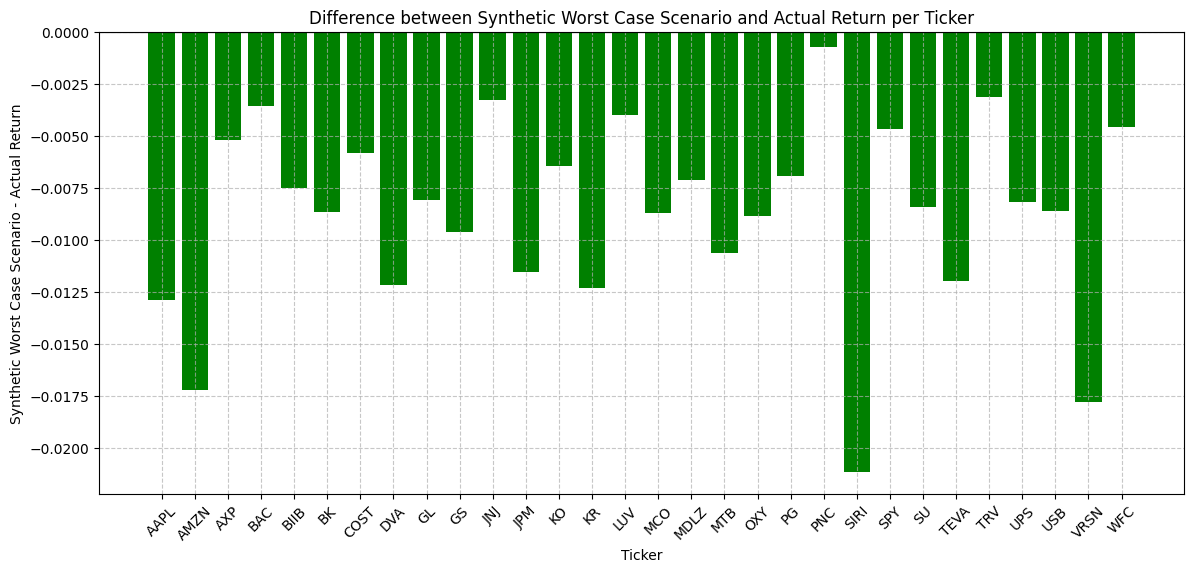

In [40]:
plot_bar_diff(hist_returns, synthetic_vars, tickers_list)

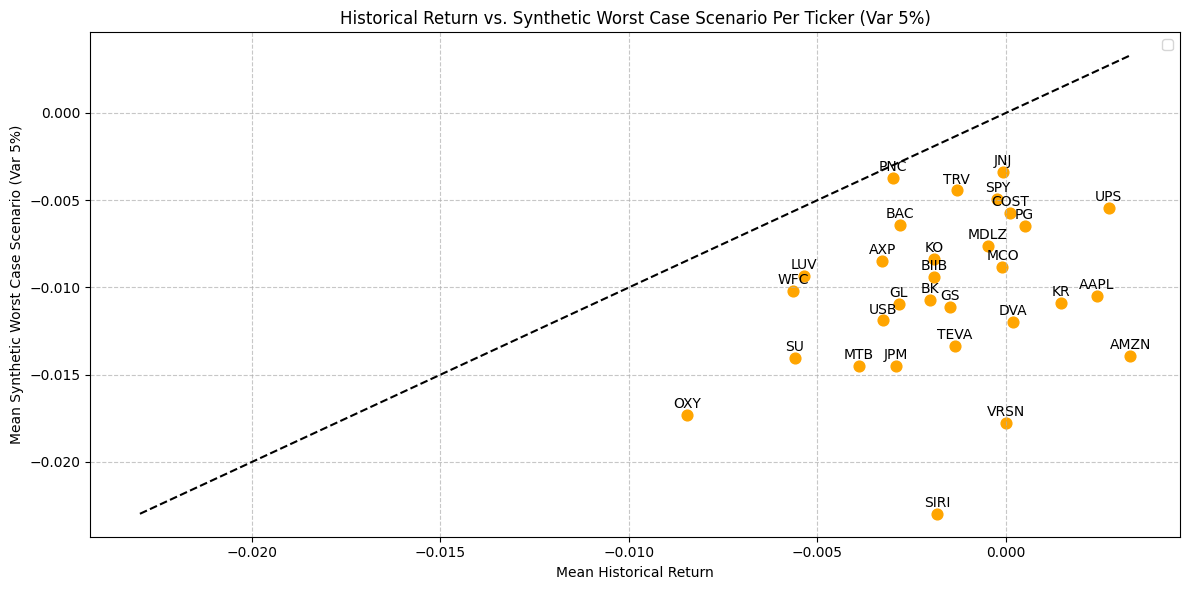

In [41]:
plot_scatter_actual_vs_synthetic_oblique(hist_returns, synthetic_vars, tickers_list)

127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step


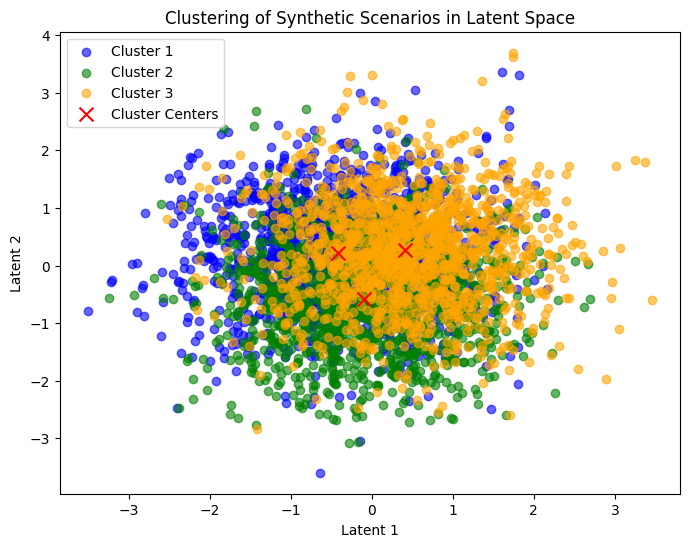

In [42]:
plot_latent_space_clustering(encoder, returns_train_scaled, SEED_RANDOM)

<a id="section_7_5"></a>
### Daily Backtesting

In [43]:
synthetic_portfolio_returns_d, var_synth_d, actual_portfolio_return_d = (
    detailed_evaluation_forecast(
        returns_test,
        input_test_scaled,
        generator,
        decoder,
        returns_scaler,
        NUM_SCENARIOS,
        NOISE_DIM,
        portfolio_weights,
        index_date=0,
    )
)

Forecast date: 2020-02-20 00:00:00
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
Detailed evaluation for forecast date: 2020-02-20 00:00:00
Synthetic Portfolio Returns - Summary:
count    10000.000000
mean        -0.037547
std          0.001093
min         -0.040145
25%         -0.038567
50%         -0.037718
75%         -0.036392
max         -0.035480
dtype: float64
Synthetic VaR (5th percentile): -0.0390
Synthetic ES: -0.0392


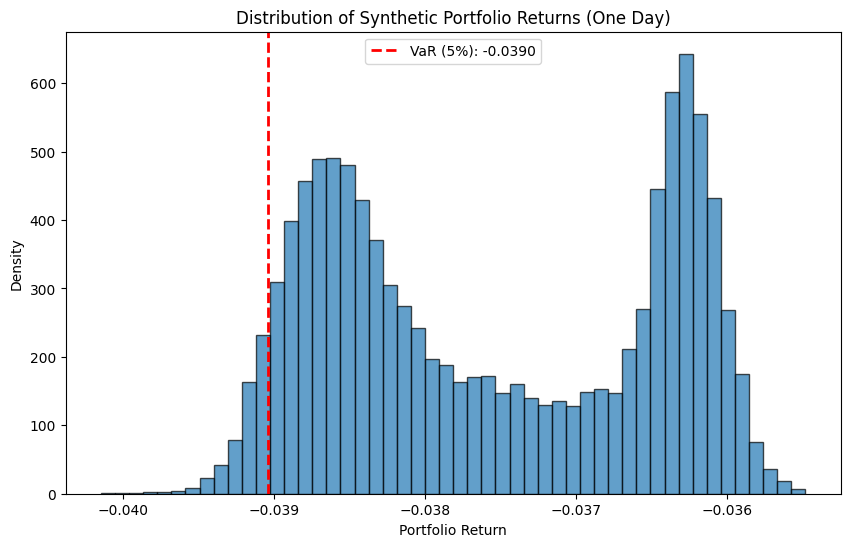

In [44]:
plot_distribution_synthetic_portfolio(synthetic_portfolio_returns_d, var_synth_d)

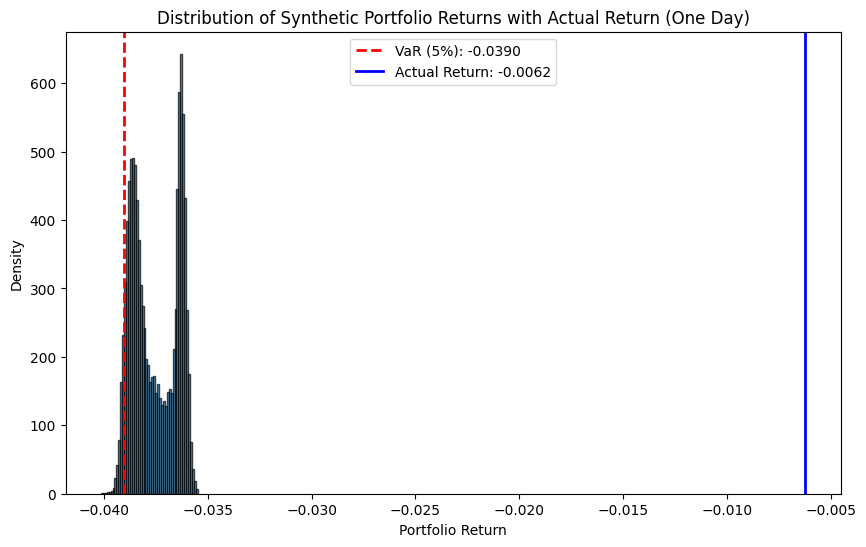

In [45]:
plot_distribution_synthetic_portfolio(
    synthetic_portfolio_returns_d, var_synth_d, actual_portfolio_return_d
)

# <a id="section_8"></a>
## Additional Validation

### Compute real and synthetic portfolio returns

In [46]:
# Flatten real portfolio returns in the backtest window
hist_portfolio_returns_window = (
    returns_test.loc[
        (returns_test.index >= backtest_start) & (returns_test.index <= backtest_end)
    ]
    .dot(portfolio_weights)
    .values
)

# Flatten synthetic returns
all_synthetic_returns = np.concatenate(backtest_df["synthetic_returns"].values)

### Filter the left tail

In [47]:
real_tail, synthetic_tail = filter_tail(
    hist_portfolio_returns_window,
    all_synthetic_returns,
    mode="negative",
)

print(f"Real tail size: {len(real_tail)}")
print(f"Synthetic tail size: {len(synthetic_tail)}")


Real tail size: 52
Synthetic tail size: 576085


### Distribution comparison metrics

In [48]:
tail_stats = compare_tail_distributions(real_tail, synthetic_tail)
print("Tail Distribution Stats:")
for k, v in tail_stats.items():
    print(f"\t{k}: {v:.4f}")

Tail Distribution Stats:
	Kolmogorov Smirnov Statistic (KS Stat): 0.1884
	KS p-value: 0.0434
	Earth Mover's Distance (EMD): 0.0059
	Jensen-Shannon Divergence (JSD): 0.1157


### Plot histogram comparison

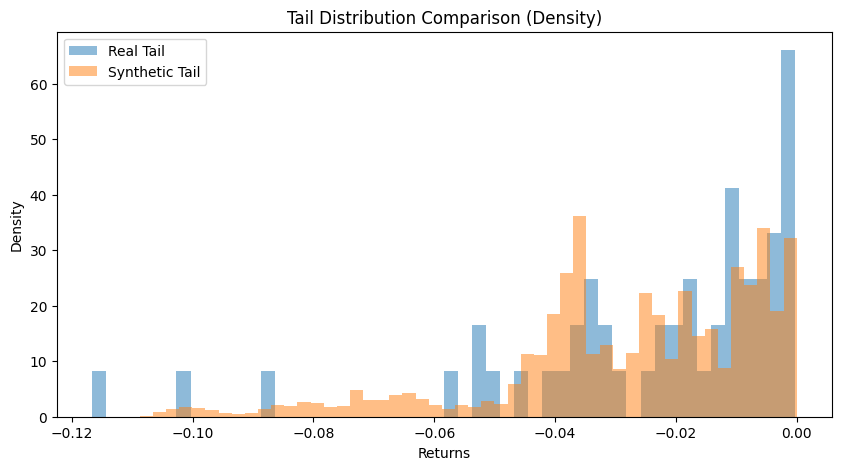

In [49]:
plot_tail_histogram(real_tail, synthetic_tail)

### Adversarial validation (Random Forest classifier)

In [50]:
adv_results = adversarial_tail_test(real_tail, synthetic_tail, seed=SEED_RANDOM)
print("Adversarial Validation:")
for k, v in adv_results.items():
    print(f"\t{k}: {v:.4f}")

Adversarial Validation:
	Train Accuracy: 1.0000
	Test Accuracy: 0.5000
